# Bi-directional Search

The point of bidirectional search is to run two simultaneous, not parallel, search from the origin and destination node hoping that they would meet in the middle.  

**but** what is the point?  

Imagine that you are doing BFS with complexity in a graph with a constant branching factor $b$ and depth $d$ so the complexity would be $O({d}^b)$ but what if we split that depth $d$ in half (that usually doesn't happen) so the total complexity would be $O({(d/2)}^b) + O({(d/2)}^b)$ which is in total much lower than $O({d}^b)$.  

Let's see some pictures, sorry for the paint-level editing in advance.

This is a uni-directional breadth first search.

![title](./data/Uni-BFS.jpg)

This is bi-directional breadth first search

![title](./data/Bi-BFS.jpg)

As you can see how many nodes that didn't contribute to the solution didn't get expanded in the bi-driectional search, cutting complexity and consumed resources drastically.

# The Algorithm

In [11]:
import osmnx as ox
import networkx as nx
from tqdm import tqdm
import time
from IPython.display import IFrame, HTML
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm
from problem import *
from utils import *

let's load our beloved UofT map

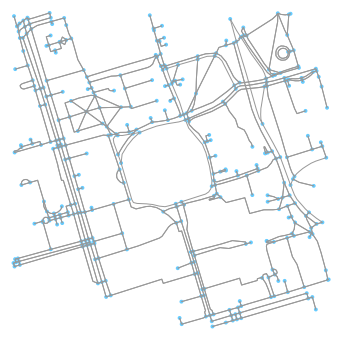

In [3]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
fig, ax = ox.plot_graph(G)

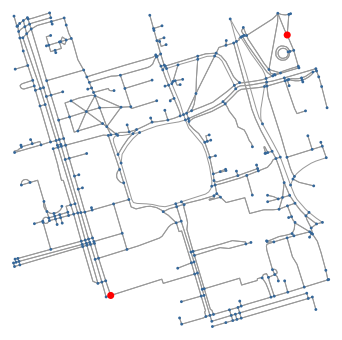

In [4]:
# marking both the source and destination node

nc = ['r' if node == 389677909 or node == 55808290 else '#336699' for node in G.nodes()]
ns = [50 if node == 389677909 or node == 55808290 else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [5]:
%%capture
source(Node)

We are implementing A* based bi-directional search algorithm, so our criteria of expansion, either from source or destination, is the sum of staright line distance between a given node and the source and the distance between the node and the destination.  

Please note the following:  

1. the origin and destination for the expansion from destionation node are reversed
2. f stands for frontier (source expansion), b stands for back (destination expansion)


In [6]:
# first define the origin/source nodes as Node
origin = Node(graph = G, node = G[55808290], osmid = 55808290, distance = 0, parent = None)
destination = Node(graph = G, node = G[389677909], osmid = 389677909)
destination_b = origin
origin_b = destination

In [7]:
toGoal_f, toDestination_f = Astar_distance(G, 55808290, 389677909)
toGoal_b, toDestination_b = Astar_distance(G, 389677909, 55808290)

In [15]:
%%time
route = []

# uncomment the following line to see the progress bar

# bar = tqdm(total=len(G))

f_value = lambda node: toGoal_f[node.osmid] + toDestination_f[node.osmid]
b_value = lambda node: toGoal_b[node.osmid] + toDestination_b[node.osmid]

queue_f = PriorityQueue('min', f_value)
queue_b = PriorityQueue('min', b_value)

queue_f.append(origin)
queue_b.append(origin_b)

explored_f = set()
explored_b = set()

collide = False
found = False

while queue_f and queue_b and not collide and not found:
    node_f = queue_f.pop()
    node_b = queue_b.pop()
#     bar.update(1); time.sleep(0.1)
    
    if f_value(node_f) < b_value(node_b):
        queue_b.append(node_b)
        explored_f.add(node_f)
        
        if node_f == destination:
            route, cost = node_f.path()
        if node_f in explored_b:
            indexable_explored = list(explored_b)
            index = indexable_explored.index(node_f)
            node_from_b = indexable_explored[index]
            route = node_f.path()[0] + [*reversed(node_from_b.path()[0])]
            collide = True
            continue
            
        for child in node_f.expand():
            if child in explored_b:
                indexable_explored = list(explored_b)
                index = indexable_explored.index(child)
                node_from_b = indexable_explored[index]
                route = child.path()[0] + [*reversed(node_from_b.path()[0])]
                collide = True
                continue
            if child not in explored_f and child not in queue_f:
                if child == destination:
                    route, cost = child.path()
                    found = True
                    continue
                queue_f.append(child)
            
            
    else:
        
        queue_f.append(node_f)
        explored_b.add(node_b)
        
        if node_b == destination_b:
            route, cost = node_b.path()
            found = True
            continue
        if node_b in explored_f:
            indexable_explored = list(explored_f)
            index = indexable_explored.index(node_b)
            node_from_f = indexable_explored[index]
            route = [*node_from_f.path()[0]] + [*reversed(node_b.path()[0])]
            collide = True
            continue
            
        for child in node_b.expand():
            if child in explored_f:
                indexable_explored = list(explored_f)
                index = indexable_explored.index(child)
                node_from_f = indexable_explored[index]
                route = [*node_from_f.path()[0]] + [*reversed(child.path()[0])]
                collide = True
                continue
            if child not in explored_b and child not in queue_b:
                if child == destination_b:
                    route, cost = child.path()
                    route = [*reversed(route)]
                    found = True
                    continue
                queue_b.append(child)

# bar.close()
print(route)

[55808290, 304891685, 55808284, 1252869817, 55808239, 389678268, 4953810915, 389678267, 24960090, 389678273, 1258698113, 389678151, 389678142, 2143489694, 389678141, 2143488528, 389678140, 389678139, 389678138, 3707407638, 6028561924, 6028561921, 389678131, 6028562356, 6028562356, 389677908, 749952029, 389677909]
CPU times: user 6.38 ms, sys: 0 ns, total: 6.38 ms
Wall time: 6.33 ms


Well, in my machine [A*](./a*_search.ipynb) took 12-15 ms but the bi-directional version here less than 5 ms max, that is for sure without using `tqdm`.

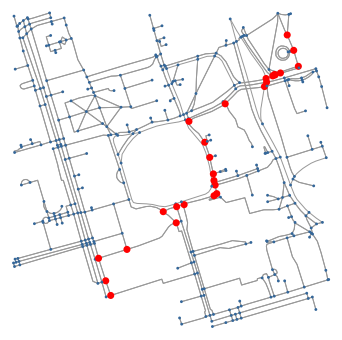

In [10]:
nc = ['r' if node in route else '#336699' for node in G.nodes()]
ns = [50 if node in route else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)